In [13]:
import matplotlib.pyplot as plt
import jax
jax.config.update('jax_default_device',jax.devices()[-1])
import jax.numpy as jnp
import optax
import jax
import numpy as np
from stochastic_interpolant.neural_network import NeuralNetwork
from stochastic_interpolant.dataloaders import (
    DatasetSampler,GaussianReferenceSampler,
    IndependenceCouplingSampler,build_trainloader,testloader_factory)
from stochastic_interpolant.loss_functions import get_trig_interpolants,root_prod_gamma,root_prod_gammadot,get_loss_functions
from stochastic_interpolant.data_generators import inf_train_gen
from stochastic_interpolant.model_training import train_model

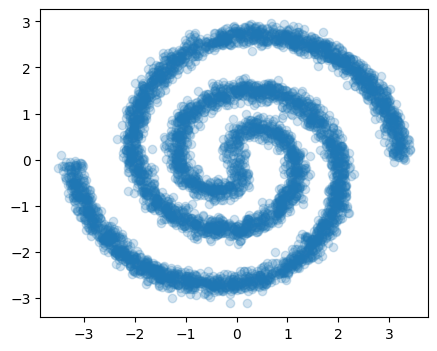

In [14]:
num_target = 5000
target_samples = inf_train_gen('2spirals',rng = 50,batch_size = num_target)
plt.figure(figsize=(5,4))
plt.scatter(target_samples[:,0],target_samples[:,1],alpha=0.2)
plt.show()

In [16]:
I,It = get_trig_interpolants()
gamma = root_prod_gamma
gammadot = root_prod_gammadot
loss_b,loss_denoise = get_loss_functions(I,It,gamma,gammadot)

b_model = NeuralNetwork(
    input_size = 3,
    output_size=2,
    layer_sizes = [256,256,256], 
    key = jax.random.PRNGKey(21239)
)
eta_model = NeuralNetwork(
    input_size = 3,
    output_size=2,
    layer_sizes = [256,256,256], 
    key = jax.random.PRNGKey(30238)
)

data_coupling_sampler = IndependenceCouplingSampler(
    GaussianReferenceSampler((2,)),
    DatasetSampler(target_samples)
    )
batch_size = 1024

train_loader = build_trainloader(batch_size,jax.random.PRNGKey(124),data_coupling_sampler)
test_factory = testloader_factory(batch_size,jax.random.PRNGKey(32498130),data_coupling_sampler)

In [23]:
b_optim = optax.nadamw(4e-4)

b_model,b_loss_history = train_model(
  model = b_model,
  optim = b_optim,
  steps = 100000,
  train_loader = train_loader,
  testloader_factory = test_factory,
  loss_fun = loss_b,
  print_every = 5000,
  num_testloader_batches = 100,
)


  0%|          | 0/100000 [00:00<?, ?it/s]

step=0 | train_loss=-2.0609777 | test_loss= -1.9841857
step=5000 | train_loss=-1.7602456 | test_loss= -2.1581755
step=10000 | train_loss=-2.3152924 | test_loss= -2.1714694
step=15000 | train_loss=-1.860326 | test_loss= -2.242855
step=20000 | train_loss=-2.053362 | test_loss= -2.279305
step=25000 | train_loss=-2.5733032 | test_loss= -2.286689
step=30000 | train_loss=-2.049432 | test_loss= -2.2587163
step=35000 | train_loss=-2.1274405 | test_loss= -2.3121386
step=40000 | train_loss=-1.9656396 | test_loss= -2.335657
step=45000 | train_loss=-2.594394 | test_loss= -2.3193705
step=50000 | train_loss=-3.0316935 | test_loss= -2.370734
step=55000 | train_loss=-2.663355 | test_loss= -2.3532681
step=60000 | train_loss=-2.0896938 | test_loss= -2.3826418
step=65000 | train_loss=-1.8151689 | test_loss= -2.3985434
step=70000 | train_loss=-3.0042815 | test_loss= -2.4138935
step=75000 | train_loss=-2.0516825 | test_loss= -2.3779538
step=80000 | train_loss=-1.8144281 | test_loss= -2.392371
step=85000 | 

In [20]:
eta_optim = optax.nadamw(4e-4)

eta_model,eta_loss_history = train_model(
  model = eta_model,
  optim = eta_optim,
  steps = 30000,
  train_loader = train_loader,
  testloader_factory = test_factory,
  loss_fun = loss_denoise,
  print_every = 5000,
  num_testloader_batches = 100,
)

  0%|          | 0/30000 [00:00<?, ?it/s]

step=0 | train_loss=0.019231874 | test_loss= -0.45985803
step=5000 | train_loss=-1.9798918 | test_loss= -1.7227664
step=10000 | train_loss=-1.8947759 | test_loss= -1.8493625
step=15000 | train_loss=-2.1774635 | test_loss= -1.9907233
step=20000 | train_loss=-2.2992246 | test_loss= -2.0361617
step=25000 | train_loss=-2.3592548 | test_loss= -2.1077502
step=29999 | train_loss=-1.8143597 | test_loss= -2.125372


  0%|          | 0/30000 [00:00<?, ?it/s]

step=0 | train_loss=0.13263732 | test_loss= -0.22044326
step=5000 | train_loss=-0.32691944 | test_loss= -0.37015113
step=10000 | train_loss=-0.34172896 | test_loss= -0.37716472
step=15000 | train_loss=-0.32266006 | test_loss= -0.38057697
step=20000 | train_loss=-0.3485942 | test_loss= -0.38102838
step=25000 | train_loss=-0.36113253 | test_loss= -0.38520634
step=29999 | train_loss=-0.4330252 | test_loss= -0.38541165


In [42]:
from stochastic_interpolant.sampler import StochasticSampler

stochastic_sampler = StochasticSampler(gamma,b_model,eta_model)
X0 = jax.random.normal(jax.random.PRNGKey(13334),(10000,2))

X,sol = stochastic_sampler.sample_trajectory(X0,eps = 0.)

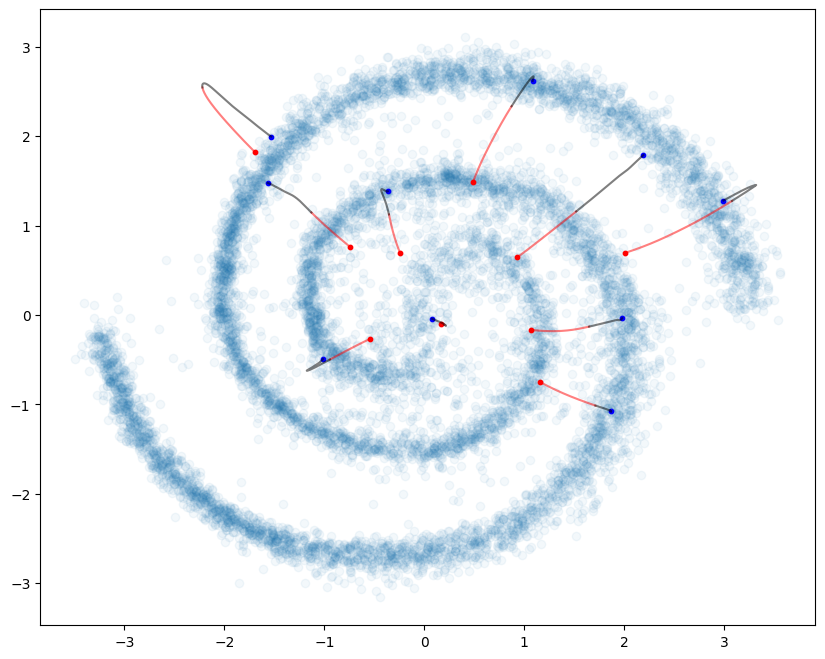

In [43]:
num_trajectories = 10

time_points = np.linspace(0,0.5,500)
plt.figure(figsize=(10,8))
plt.scatter(X[:,0],X[:,1],alpha = 0.05)

path = jnp.array([sol.evaluate(t)[:num_trajectories] for t in time_points])
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1],c = 'red',alpha = 0.5)

time_points = np.linspace(0.5,1.,500)
path = jnp.array([sol.evaluate(t)[:num_trajectories] for t in time_points])
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1],c='black',alpha = 0.5)

plt.scatter(X0[:num_trajectories,0],X0[:num_trajectories,1],c = 'red',s = 10.)

plt.scatter(X[:num_trajectories,0],X[:num_trajectories,1],c = 'blue',s = 10.)
plt.show()

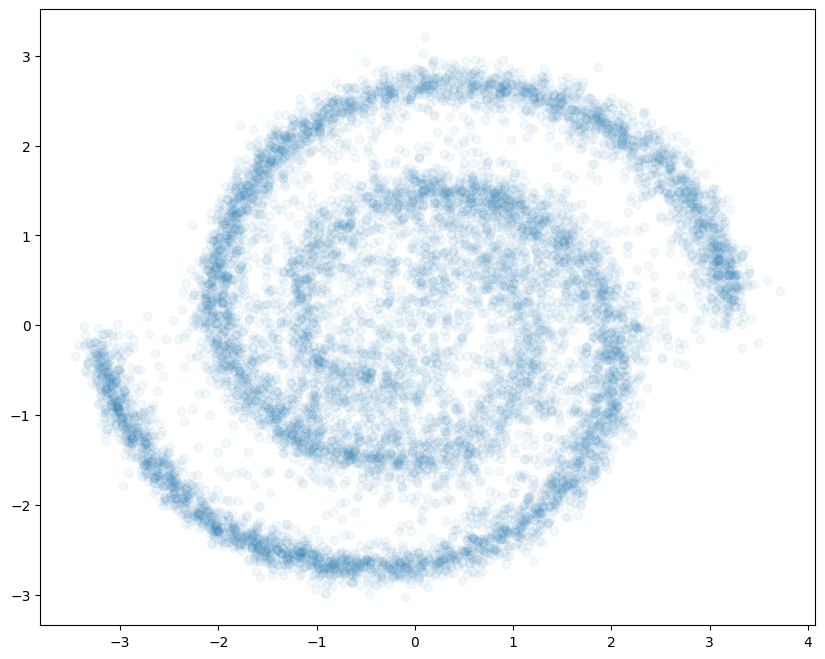

In [37]:
plt.figure(figsize=(10,8))
plt.scatter(X[:,0],X[:,1],alpha = 0.05)


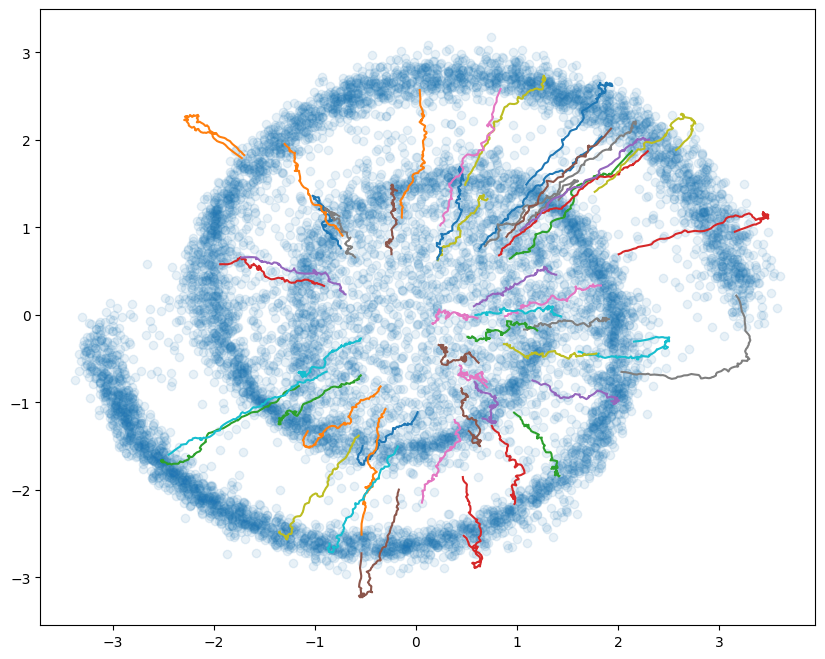

In [44]:
time_points = np.linspace(0,1,100)

path = jnp.array([sol.evaluate(t)[:50] for t in time_points])
plt.figure(figsize=(10,8))
plt.scatter(X[:,0],X[:,1],alpha = 0.1)
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1])

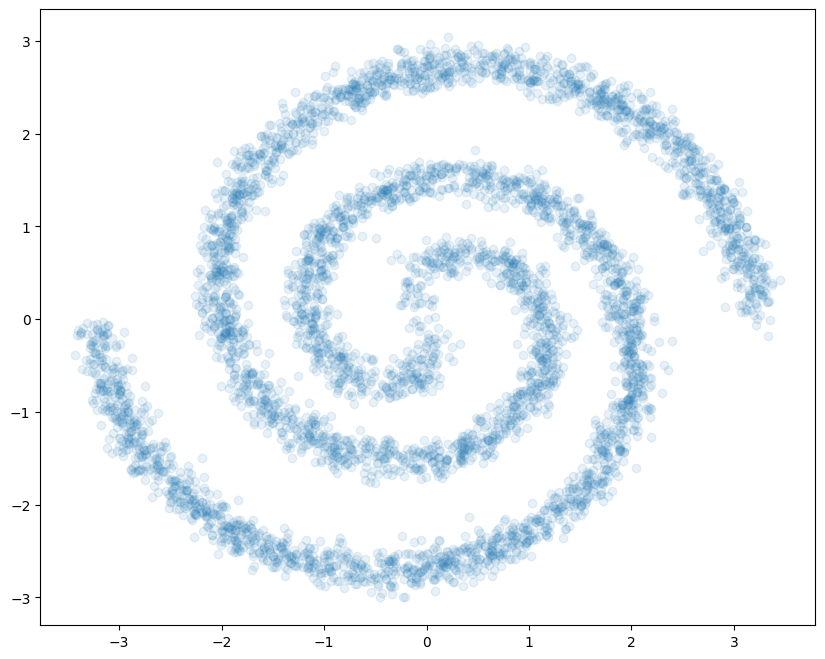

In [9]:
plt.figure(figsize=(10,8))
plt.scatter(target_samples[:,0],target_samples[:,1],alpha = 0.1)
